# GraphML Session 03


## OSM Analysis

Here we'll add weights to our graph based on nearby amenities as described in Open Street Maps.

In [1]:
!pip install osmnx

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

 Divide the City into Grid Cells

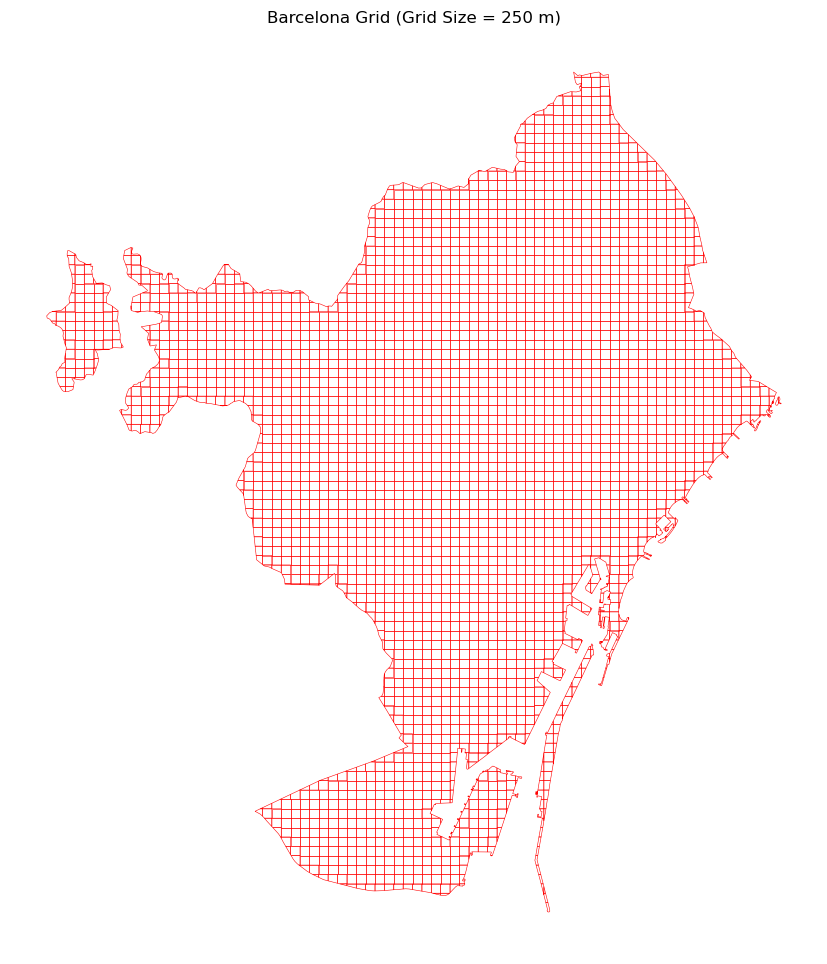

In [11]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

# Get city boundary
barcelona = ox.geocode_to_gdf("Barcelona, Spain").to_crs(epsg=3857)

# Grid size in meters – change this value to test
grid_size = 250  # Try 150, 200, etc.

# Generate grid
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []
for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cells.append(box(x, y, x + grid_size, y + grid_size))
grid = gpd.GeoDataFrame(geometry=cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Tilted grid to match Eixample

C:\Users\DELL\AppData\Local\Temp\ipykernel_33024\3216475066.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = barcelona.geometry.unary_union.centroid.coords[0]


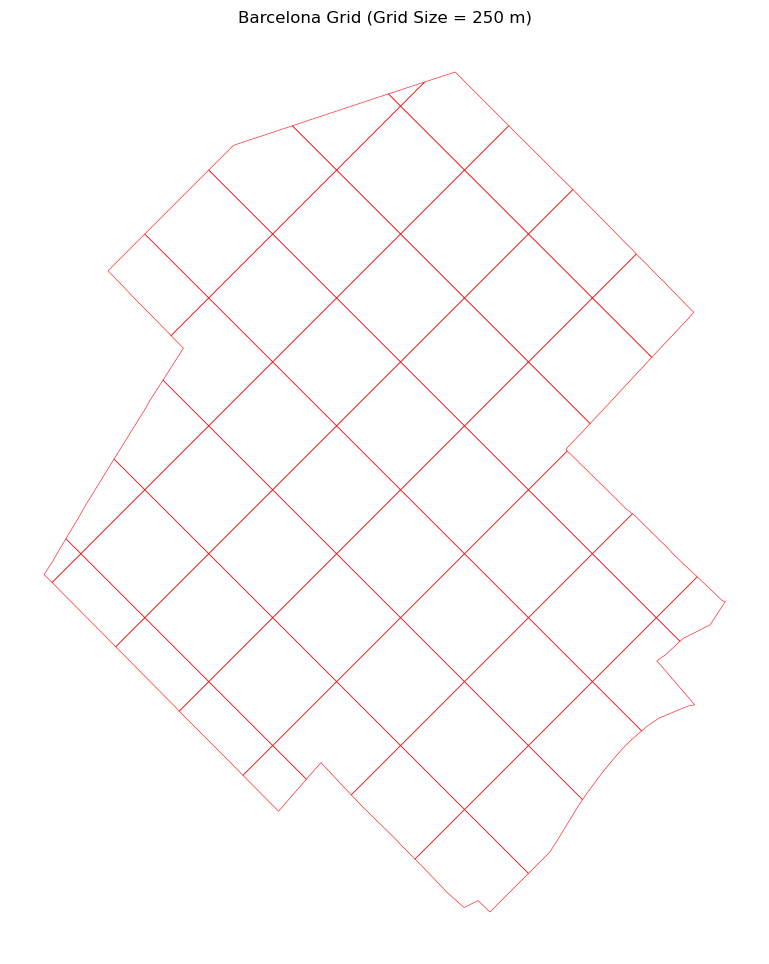

In [32]:
from shapely import affinity

# 1. Define the rotation angle (in degrees)
rotation_angle = -45  # Eixample tilt is ~30° clockwise → -30 to rotate clockwise
# Get city boundary
barcelona = ox.geocode_to_gdf("Poblenou, Barcelona, Spain").to_crs(epsg=3857)
# 2. Generate the grid
grid_size = 250  # Use Eixample-like block size
minx, miny, maxx, maxy = barcelona.total_bounds
cells = []

for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        cell = box(x, y, x + grid_size, y + grid_size)
        cells.append(cell)

# 3. Apply rotation around the center of the city
cx, cy = barcelona.geometry.unary_union.centroid.coords[0]
rotated_cells = [affinity.rotate(cell, rotation_angle, origin=(cx, cy)) for cell in cells]

# 4. Create GeoDataFrame and clip
grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=barcelona.crs)
grid = gpd.overlay(grid, barcelona, how="intersection")
grid["cell_id"] = range(len(grid))
# Plot the grid only
fig, ax = plt.subplots(figsize=(12, 12))
grid.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=0.4)
plt.title(f"Barcelona Grid (Grid Size = {grid_size} m)")
plt.axis("off")
plt.show()


Download Streets + Buildings for Background

In [20]:
# Download streets and building footprints
G = ox.graph_from_place("Poblenou, Barcelona, Spain", network_type="drive")
streets = ox.graph_to_gdfs(G, nodes=False, edges=True).to_crs(epsg=3857)
buildings = ox.features_from_place("Poblenou,Barcelona, Spain", tags={"building": True})



 Plot Everything Together

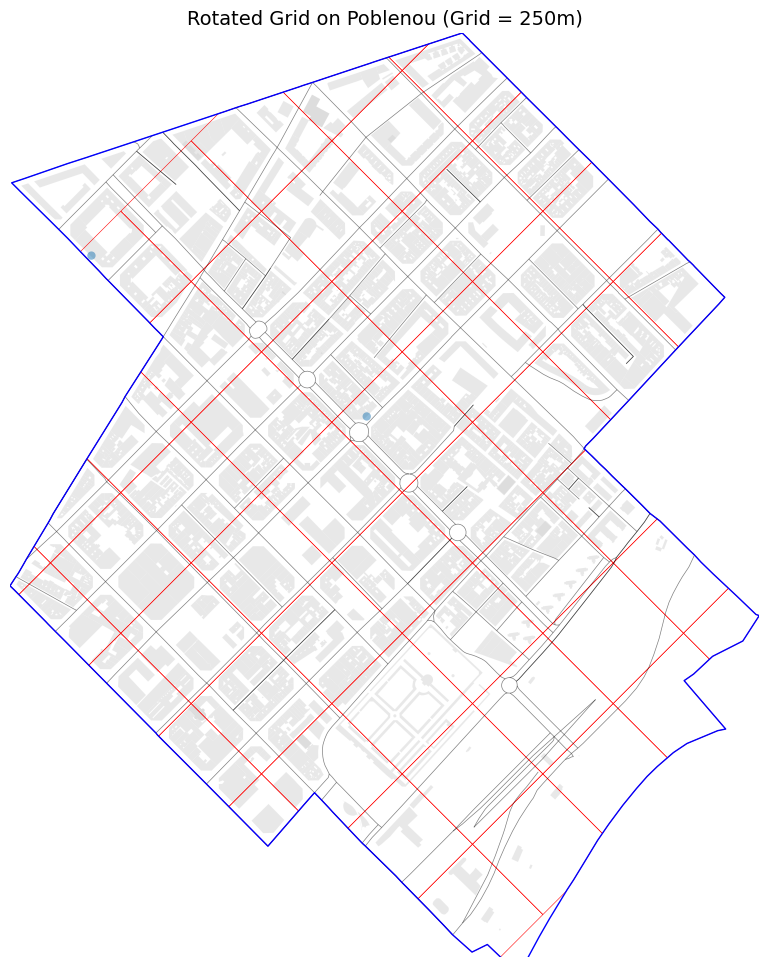

In [33]:
# Reproject buildings to match grid
buildings = buildings.to_crs(epsg=3857)
# Plot everything
fig, ax = plt.subplots(figsize=(12, 12))
streets.plot(ax=ax, linewidth=0.5, color="black", alpha=0.5)
buildings.plot(ax=ax, facecolor="lightgray", edgecolor="none", alpha=0.5)
grid.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.4)
barcelona.boundary.plot(ax=ax, edgecolor="blue", linewidth=1)

# Zoom into the actual grid area
ax.set_xlim(grid.total_bounds[0], grid.total_bounds[2])
ax.set_ylim(grid.total_bounds[1], grid.total_bounds[3])
ax.set_aspect("equal")

plt.title(f"Rotated Grid on Poblenou (Grid = {grid_size}m)", fontsize=14)
plt.axis("off")
plt.show()

##GridGenerator Class

In [35]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
from shapely import affinity
import numpy as np

class RotatedGridGenerator:
    def __init__(self, place_name, grid_size=113, rotation_angle=-45):
        """
        place_name: str - the name of the location (e.g. "Poblenou, Barcelona, Spain")
        grid_size: int - the grid cell size in meters (width = height)
        rotation_angle: float - clockwise rotation in degrees (e.g., -45)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle
        self.city_boundary = self._get_boundary()
        self.crs = self.city_boundary.crs
        self.grid = self._generate_rotated_grid()

    def _get_boundary(self):
        """Download and return the city or neighborhood boundary"""
        return ox.geocode_to_gdf(self.place_name).to_crs(epsg=3857)

    def _generate_rotated_grid(self):
        """Create a rotated square grid clipped to the city boundary"""
        minx, miny, maxx, maxy = self.city_boundary.total_bounds
        cells = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                cell = box(x, y, x + self.grid_size, y + self.grid_size)
                cells.append(cell)

        # Rotate grid around city center
        cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, self.rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=self.crs)
        grid = gpd.overlay(grid, self.city_boundary, how="intersection")
        grid["cell_id"] = range(len(grid))
        return grid

    def get_grid(self):
        """Return the rotated clipped grid as a GeoDataFrame"""
        return self.grid

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax


C:\Users\DELL\AppData\Local\Temp\ipykernel_33024\2233986745.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]


<Axes: title={'center': 'Rotated Grid on Poblenou, Barcelona, Spain (size=226m, angle=-45°)'}>

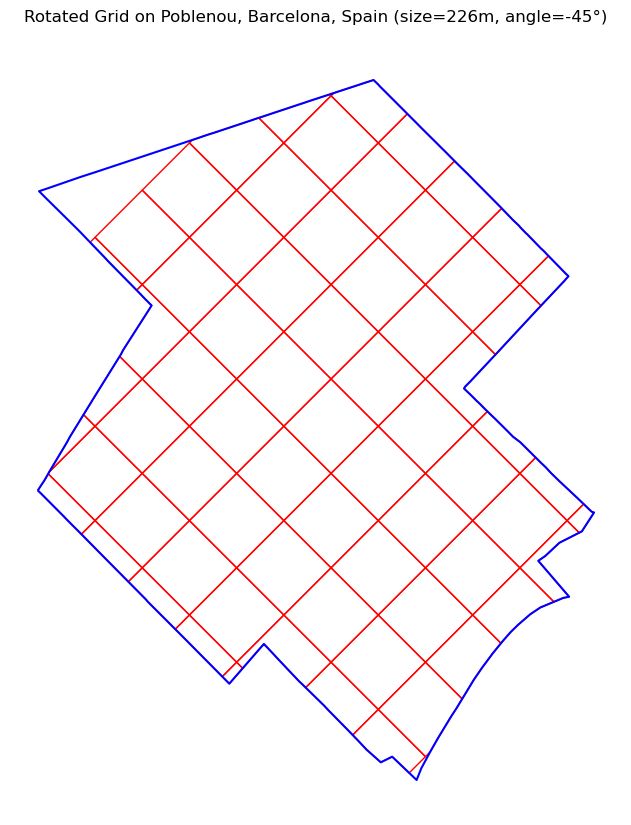

In [36]:
# Create a grid over Poblenou, with 2x2 blocks per cell (~226m), rotated 45°
gridgen = RotatedGridGenerator("Poblenou, Barcelona, Spain", grid_size=226, rotation_angle=-45)

# Get the grid as GeoDataFrame
grid = gridgen.get_grid()

# Plot it
gridgen.plot()


##AMENITIES

We start by gettin a location:

In [37]:
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type="drive")


Next, we define what kind of "amenities" do we want to extract from OSM.

Key values to look for refer to https://wiki.openstreetmap.org/wiki/Map_Features


In [38]:
# set value to True for all values pairable to the key
key = "amenity"
value = ["bar","restaurant","pub","cafe","fast_food"]

# Download the Points of interest
tags = {key: value}
gdf = ox.features_from_place(place_name, tags=tags)
gdf

geometry  \
element id                                                              
node    660100527                            POINT (2.19677 41.40469)   
        660100529                            POINT (2.19419 41.40486)   
        660771772                             POINT (2.19776 41.4035)   
        660778771                             POINT (2.19865 41.4029)   
        660784487                             POINT (2.1989 41.40273)   
...                                                               ...   
way     217583616   POLYGON ((2.2063 41.39474, 2.20638 41.39468, 2...   
        412702054   POLYGON ((2.20418 41.39528, 2.2042 41.39527, 2...   
        1367091257  POLYGON ((2.2056 41.39331, 2.20564 41.39337, 2...   
        1367091871  POLYGON ((2.20644 41.39433, 2.2065 41.39439, 2...   
        1367092595  POLYGON ((2.20785 41.39543, 2.20789 41.39546, ...   

                       amenity  cuisine                             name  \
element id                                                                 
node    660100527         cafe  spanish                  Rambla Poblenou   
        660100529         cafe      NaN                        El Fornet   
        660771772    fast_food  chicken                           Apluma   
        660778771   restaurant  spanish                   braseria xorus   
        660784487   restaurant      NaN                      La broqueta   
...                        ...      ...                              ...   
way     217583616   restaurant  seafood                       Can Fisher   
        412702054         cafe      NaN                          Camping   
        1367091257        cafe      NaN                          Bo Kaap   
        1367091871        cafe      NaN                        Vai Moana   
        1367092595        cafe      NaN  Barcelona beach. El Chiringuito   

                        shop indoor_seating outdoor_seating  \
element id                                                    
node    660100527   optician            NaN             NaN   
        660100529        NaN            yes             yes   
        660771772        NaN            NaN             NaN   
        660778771        NaN            yes             yes   
        660784487        NaN            NaN             NaN   
...                      ...            ...             ...   
way     217583616        NaN            NaN             yes   
        412702054        NaN            NaN             NaN   
        1367091257       NaN            NaN             NaN   
        1367091871       NaN            NaN             NaN   
        1367092595       NaN            NaN             NaN   

                                     website addr:housenumber addr:postcode  \
element id                                                                    
node    660100527                        NaN              NaN           NaN   
        660100529   https://elfornet.com/es/              NaN           NaN   
        660771772    https://www.apluma.com/              117         08018   
        660778771                        NaN              105           NaN   
        660784487                        NaN              NaN           NaN   
...                                      ...              ...           ...   
way     217583616                        NaN              NaN           NaN   
        412702054                        NaN              NaN           NaN   
        1367091257                       NaN              NaN           NaN   
        1367091871                       NaN              NaN           NaN   
        1367092595                       NaN              NaN           NaN   

                    ... image payment:cards name:ro building contact:city  \
element id          ...                                                     
node    660100527   ...   NaN           NaN     NaN      NaN          NaN   
        660100529   ...   NaN           NaN

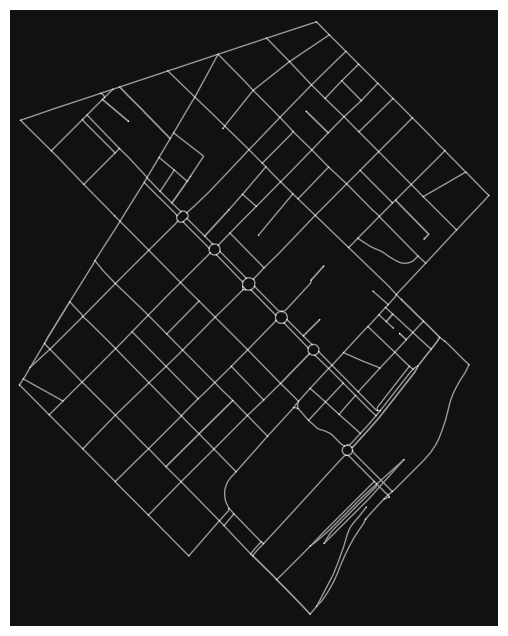

(237, 76)

In [39]:
ox.plot_graph(G, node_size=1)
gdf.shape

In [40]:
# Filter out non-points geometry
gdf_pts = gdf.loc[gdf.geometry.geometry.type=='Point']
gdf_pts.shape
gdf_pts

geometry     amenity  \
element id                                                  
node    660100527    POINT (2.19677 41.40469)        cafe   
        660100529    POINT (2.19419 41.40486)        cafe   
        660771772     POINT (2.19776 41.4035)   fast_food   
        660778771     POINT (2.19865 41.4029)  restaurant   
        660784487     POINT (2.1989 41.40273)  restaurant   
...                                       ...         ...   
        12546429118  POINT (2.19897 41.39577)  restaurant   
        12628316609  POINT (2.20449 41.39877)        cafe   
        12691417681   POINT (2.19818 41.4043)        cafe   
        12837309875  POINT (2.19937 41.40049)        cafe   
        12878647527  POINT (2.19749 41.39907)        cafe   

                                          cuisine             name      shop  \
element id                                                                     
node    660100527                         spanish  Rambla Poblenou  optician   
        660100529                             NaN        El Fornet       NaN   
        660771772                         chicken           Apluma       NaN   
        660778771                         spanish   braseria xorus       NaN   
        660784487                             NaN      La broqueta       NaN   
...                                           ...              ...       ...   
        12546429118                           NaN             Miny       NaN   
        12628316609                           NaN    Repúblic Cafè       NaN   
        12691417681  coffee_shop;breakfast;brunch         Osom Nou       NaN   
        12837309875                           NaN           Labath       NaN   
        12878647527                           NaN        Mono Cafe       NaN   

                    indoor_seating outdoor_seating                   website  \
element id                                                                     
node    660100527              NaN             NaN                       NaN   
        660100529              yes             yes  https://elfornet.com/es/   
        660771772              NaN             NaN   https://www.apluma.com/   
        660778771              yes             yes                       NaN   
        660784487              NaN             NaN                       NaN   
...                            ...             ...                       ...   
        12546429118            NaN             NaN                       NaN   
        12628316609            NaN             NaN                       NaN   
        12691417681            NaN             NaN    https://somososom.com/   
        12837309875            NaN             NaN                       NaN   
        12878647527            yes              no                       NaN   

                    addr:housenumber addr:postcode  ... image payment:cards  \
element id                                          ...                       
node    660100527                NaN           NaN  ...   NaN           NaN   
        660100529                NaN           NaN  ...   NaN           NaN   
        660771772                117         08018  ...   NaN           NaN   
        660778771                105           NaN  ...   NaN           NaN   
        660784487                NaN           NaN  ...   NaN           NaN   
...                              ...           ...  ...   ...           ...   
        12546429118              NaN           NaN  ...   NaN           NaN   
        12628316609               22           NaN  ...   NaN           NaN   
        12691417681              148         08018  ...   NaN           NaN   
        12837309875              NaN           NaN  ...   NaN           NaN   
        12878647527              NaN           NaN  ...   NaN           NaN   

                    name:ro building contact:city contact:housenumber  \
element id                                                  

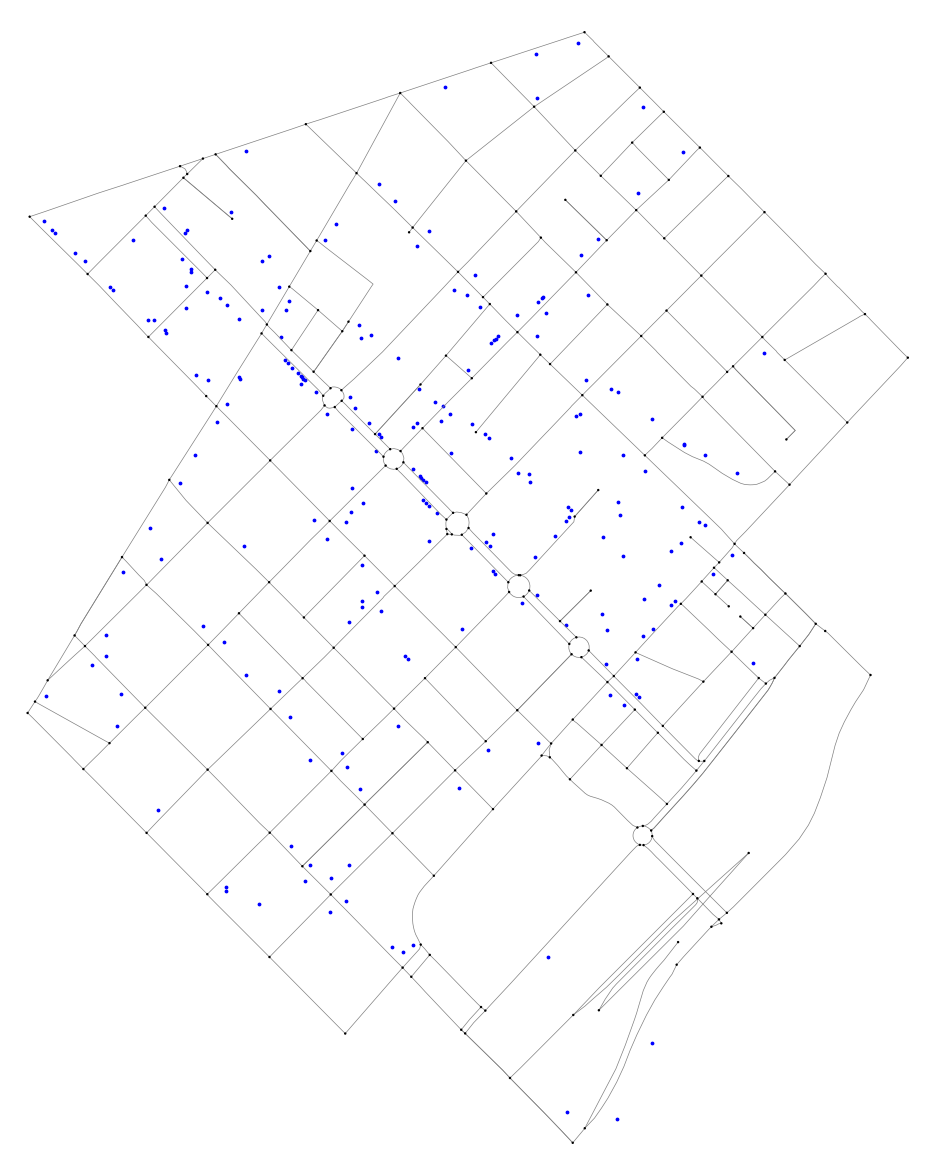

In [41]:
# Start plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot GeoDataFrame
gdf_pts.plot(ax=ax, color='blue', markersize=3)

# Draw the graph
ox.plot_graph(G, ax=ax, node_size=3, node_color= "black", edge_linewidth=0.5, edge_color='gray')

plt.show()

In [ ]:
# Reproject to a projected crs (meters)
crs = 3857 #mercator

G_proj = ox.projection.project_graph(G, to_crs=crs)
gdf_pts_proj = ox.projection.project_gdf(gdf_pts, to_crs=crs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
display(pd.DataFrame(gdf_pts_proj['geometry']))
display(pd.DataFrame(gdf_pts_proj['geometry'].x))
pd.DataFrame(gdf_pts_proj['geometry'].y)

geometry
element_type osmid                                      
node         364731424    POINT (240692.432 5069966.425)
             570117144    POINT (240710.710 5071843.304)
             587998431    POINT (240691.641 5071825.154)
             588002549    POINT (240666.271 5071802.715)
             588003295    POINT (240672.962 5071809.007)
...                                                  ...
             11802841810  POINT (239038.892 5071227.234)
             11817152012  POINT (239606.298 5071901.659)
             11819919935  POINT (239645.739 5072161.365)
             11853973569  POINT (240001.104 5069819.397)
             11854061692  POINT (241255.241 5071107.313)

[1422 rows x 1 columns]

0
element_type osmid                     
node         364731424    240692.431513
             570117144    240710.710173
             587998431    240691.641145
             588002549    240666.271433
             588003295    240672.961734
...                                 ...
             11802841810  239038.891797
             11817152012  239606.298373
             11819919935  239645.738869
             11853973569  240001.104079
             11854061692  241255.240595

[1422 rows x 1 columns]

0
element_type osmid                    
node         364731424    5.069966e+06
             570117144    5.071843e+06
             587998431    5.071825e+06
             588002549    5.071803e+06
             588003295    5.071809e+06
...                                ...
             11802841810  5.071227e+06
             11817152012  5.071902e+06
             11819919935  5.072161e+06
             11853973569  5.069819e+06
             11854061692  5.071107e+06

[1422 rows x 1 columns]

In [ ]:
# Get the nearest edge per point
G_dist = ox.distance.nearest_edges(G_proj, X=gdf_pts_proj['geometry'].x, Y=gdf_pts_proj['geometry'].y)

In [ ]:
G_dist

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(30247434, 10181609589, 0),
 (30554511, 30554509, 0),
 (30554511, 30554509, 0),
 (30554511, 30554509, 0),
 (30554511, 30554509, 0),
 (415935008, 30553978, 0),
 (30558446, 6238824734, 0),
 (30237643, 30237642, 0),
 (1400448338, 1400448339, 0),
 (11466476299, 11466476297, 0),
 (11466476299, 11466476297, 0),
 (11466476299, 11466476297, 0),
 (11466476299, 11466476297, 0),
 (11466476299, 11466476297, 0),
 (442540236, 442540237, 0),
 (442540236, 442540237, 0),
 (269369082, 442540235, 0),
 (269369082, 442540235, 0),
 (11053280241, 442540253, 0),
 (301572132, 301572243, 0),
 (301573106, 301573130, 0),
 (301573106, 301573130, 0),
 (301572963, 10181609585, 0),
 (30554971, 30554851, 0),
 (30554971, 30554851, 0),
 (30554850, 567448762, 0),
 (30237698, 30237699, 0),
 (30237641, 30237699, 0),
 (30237641, 30237699, 0),
 (30237641, 30237640, 0),
 (30237640, 30237639, 0),
 (30237641, 30237640, 0),
 (30237698, 30237699, 0),
 (30237698, 30237699, 0),
 (30237698, 30237699, 0),
 (30237640, 30237698, 0),
 

In [ ]:
# Decompose the graph
G_nodes, G_edges = ox.graph_to_gdfs(G_proj)

In [ ]:
# Count occurences in distance df
occurences = Counter(G_dist)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
occurences

Counter({(30247434, 10181609589, 0): 5,
         (30554511, 30554509, 0): 5,
         (415935008, 30553978, 0): 1,
         (30558446, 6238824734, 0): 2,
         (30237643, 30237642, 0): 7,
         (1400448338, 1400448339, 0): 3,
         (11466476299, 11466476297, 0): 11,
         (442540236, 442540237, 0): 2,
         (269369082, 442540235, 0): 2,
         (11053280241, 442540253, 0): 6,
         (301572132, 301572243, 0): 2,
         (301573106, 301573130, 0): 5,
         (301572963, 10181609585, 0): 1,
         (30554971, 30554851, 0): 10,
         (30554850, 567448762, 0): 3,
         (30237698, 30237699, 0): 7,
         (30237641, 30237699, 0): 3,
         (30237641, 30237640, 0): 7,
         (30237640, 30237639, 0): 4,
         (30237640, 30237698, 0): 2,
         (30247089, 30238023, 0): 5,
         (559787231, 559787232, 0): 3,
         (30243263, 33098963, 0): 5,
         (30556631, 30254381, 0): 1,
         (30243202, 30243203, 0): 3,
         (30333330, 30556748, 0): 7,
 

In [ ]:
type(occurences)

collections.Counter

In [ ]:
occurences_df = pd.DataFrame(list(occurences.items()), columns=['name', 'count'])
occurences_df

,name,count
0,"(30247434, 10181609589, 0)",5
1,"(30554511, 30554509, 0)",5
2,"(415935008, 30553978, 0)",1
3,"(30558446, 6238824734, 0)",2
4,"(30237643, 30237642, 0)",7
...,...,...
500,"(30333325, 3053342333, 0)",1
501,"(30333343, 30254369, 0)",3
502,"(30238032, 30243261, 0)",1
503,"(30248594, 30248595, 0)",1


In [ ]:
for item, count in occurences.most_common(10):
    print(item, count)

(30554852, 30554851, 0) 12
(11061736176, 10181609591, 0) 12
(11466476299, 11466476297, 0) 11
(30237700, 30237642, 0) 11
(3184416495, 11012442316, 0) 11
(10181609589, 10181609585, 0) 11
(30554971, 30554851, 0) 10
(301572460, 344992889, 0) 10
(301572963, 30247434, 0) 10
(30243322, 30243323, 0) 9


In [ ]:
for i in G_edges.index:
    print(i)
    # print(G_edges.loc[i])
    # print(G_edges['name'])
    # print(G_edges.loc[i].name)

(26057312, 269369082, 0)
(26057312, 3229689808, 0)
(269369082, 442540235, 0)
(269369082, 1311770050, 0)
(3229689808, 30254225, 0)
(30237612, 30237613, 0)
(30237612, 30247089, 0)
(30237613, 30237633, 0)
(30237613, 30237614, 0)
(30247089, 2494769767, 0)
(30247089, 30238023, 0)
(30237633, 1311773901, 0)
(30237633, 30237632, 0)
(30237614, 30237615, 0)
(30237614, 30237696, 0)
(30237615, 30237635, 0)
(30237615, 30237616, 0)
(30237696, 30237772, 0)
(30237696, 30237697, 0)
(30237635, 30237634, 0)
(30237635, 30237637, 0)
(30237616, 30247166, 0)
(30237616, 30237617, 0)
(30247166, 30237638, 0)
(30247166, 30247167, 0)
(30237617, 30247432, 0)
(30247432, 30247166, 0)
(30247432, 30247433, 0)
(30237632, 30237612, 0)
(1311773901, 30237770, 0)
(30237634, 30237614, 0)
(30237634, 30237633, 0)
(30237637, 30247431, 0)
(30237637, 1362899971, 0)
(30247431, 1311619368, 0)
(30247431, 30237617, 0)
(1362899971, 1311619488, 0)
(1362899971, 1311619340, 0)
(1362899971, 359104407, 0)
(30237638, 30237615, 0)
(30237638

In [ ]:
# Initialize empty list for values
cost = [] # number of occurences

# Map occurences to G_edge df
for i in G_edges.index:
    # print(i)
    # print(G_edges.loc[i])
    # print(G_edges.loc[i].name)
    # the referance goes to dictionary
    occurence = occurences[G_edges.loc[i].name]
    # print(occurence)
    cost.append(occurence)

# Double check that remapping worked
print( 'remapped pts:',sum(cost),'/', len(G_dist))

# Harmonize weights?
# cost = [item / max(cost) for item in cost]

# Update the graph
G_edges['repulsive'] = cost # this is inverse of attractive, here we take the shortest path by using the minimum amenities number out of collected numbers
G_edges['attractive'] = [((max(cost))-item) for item in cost] # this is inverse of repulsive, here we take the shortest path, that is the smallest weight of max-number

G_cost = ox.graph_from_gdfs(G_nodes,G_edges)

remapped pts: 1422 / 1422


In [ ]:
ex_repulsive = [5, 12, 3, 7, 2, 8, 5, 12, 3, 2, 8, 5]
ex_attractive = [max(ex_repulsive) - el for el in ex_repulsive]
# the negative inverse is not possible, as shortest_path should work with positive numbers
print(f'REPULSIVE: the initial list of weights: {ex_repulsive}, the shortest_path will pick the street with a smallest number')
print(f'ATTRACTIVE: the (max-initial), INVERSED list of weights: {ex_attractive}, the shortest path will pick the smallest item from list, that will represent the most crowded street')

REPULSIVE: the initial list of weights: [5, 12, 3, 7, 2, 8, 5, 12, 3, 2, 8, 5], the shortest_path will pick the street with a smallest number
ATTRACTIVE: the (max-initial), INVERSED list of weights: [7, 0, 9, 5, 10, 4, 7, 0, 9, 10, 4, 7], the shortest path will pick the smallest item from list, that will represent the most crowded street


In [ ]:
G_edges

osmid  oneway lanes  \
u           v           key                                        
26057312    269369082   0                304693491    True     4   
            3229689808  0                545718428    True     2   
269369082   442540235   0                116343002    True     1   
            1311770050  0                116343003    True     4   
3229689808  30254225    0    [18522669, 545718430]    True     5   
...                                            ...     ...   ...   
11282472009 1377225915  0               1217655906    True   NaN   
11282472015 11282472009 0               1217655905    True   NaN   
            11276298354 0               1217655908    True     4   
11289475293 126797988   0                876196208    True   NaN   
11466476297 559765964   0                  8380873    True     1   

                                                          name        highway  \
u           v           key                                                     
26057312    269369082   0                    Passeig de Gràcia       tertiary   
            3229689808  0      Gran Via de les Corts Catalanes        primary   
269369082   442540235   0    Passeig de Gràcia (lateral Besòs)  living_street   
            1311770050  0                    Passeig de Gràcia       tertiary   
3229689808  30254225    0      Gran Via de les Corts Catalanes        primary   
...                                                        ...            ...   
11282472009 1377225915  0                    Passeig de Gràcia       tertiary   
11282472015 11282472009 0                    Passeig de Gràcia       tertiary   
            11276298354 0                Plaça del Cinc d'Oros      secondary   
11289475293 126797988   0     Plaça de Mossèn Jacint Verdaguer       tertiary   
11466476297 559765964   0                  Rambla de Catalunya    residential   

                            maxspeed width reversed   length  \
u           v           key                                    
26057312    269369082   0         50     8    False   12.051   
            3229689808  0         50    14    False   15.587   
269369082   442540235   0         10   NaN    False  130.310   
            1311770050  0         50   NaN    False   31.357   
3229689808  30254225    0         50    14    False  155.871   
...                              ...   ...      ...      ...   
11282472009 1377225915  0        NaN   NaN    False   15.770   
11282472015 11282472009 0        NaN   NaN    False   11.793   
            11276298354 0         30   NaN    False   14.941   
11289475293 126797988   0         30    15    False   13.360   
11466476297 559765964   0         30   NaN    False   22.244   

                                                                      geometry  \
u           v           key                                                      
26057312    269369082   0    LINESTRING (241381.844 5069977.495, 241371.736...   
            3229689808  0    LINESTRING (241381.844 5069977.495, 241397.173...   
269369082   442540235   0    LINESTRING (241368.953 5069986.902, 241366.950...   
            1311770050  0    LINESTRING (241368.953 5069986.902, 241346.088...   
3229689808  30254225    0    LINESTRING (241401.592 5069984.023, 241407.314...   
...                                                                        ...   
11282472009 1377225915  0    LINESTRING (240401.142 5070983.105, 240414.244...   
11282472015 11282472009 0    LINESTRING (240387.917 5070991.638, 240394.362...   
            11276298354 0    LINESTRING (240387.917 5070991.638, 240397.157...   
11289475293 126797988   0    LINESTRING (241568.661 5071415.347, 241566.267...   
11466476297 559765964   0    LINESTRING (241261.564 5069782.184, 241254.729...   

                              ref est_width access  junction  repulsive  \
u           v           key                                               
26057312    269369082   0     NaN       NaN    NaN      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


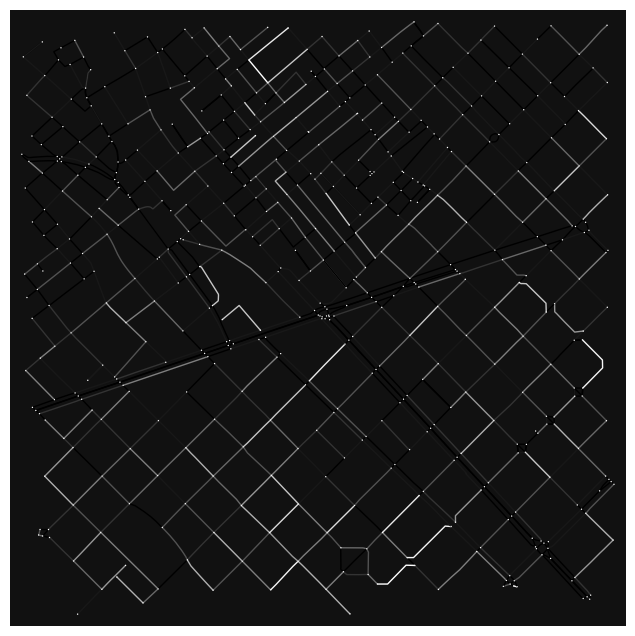

In [ ]:
# Plot graph with custom weights
ec = ox.plot.get_edge_colors_by_attr(G_cost, attr="repulsive",  cmap="Greys_r")

fig, ax = ox.plot_graph(G_cost, node_size=1, edge_color=ec, edge_linewidth=1)

In [ ]:
# Calculate Shortest path with custom weight
orig = list(G_cost)[1]
dest = list(G_cost)[300]

route_cost = ox.shortest_path(G_cost, orig, dest, weight="repulsive")
route_cost_neg = ox.shortest_path(G_cost, orig, dest, weight="attractive")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get source node(s)
source_node = [orig]
# iterate through the nodes and apply parameters
node_color = ['red' if node in source_node else 'white' for node in G.nodes()]
node_size = [100 if node in source_node else 5 for node in G.nodes()]

In [ ]:
route_cost

[269369082,
 1311770050,
 30243053,
 30242864,
 33098957,
 1311770048,
 30243371,
 1311770053,
 1311770051,
 1377225915,
 11282472027,
 1311619517,
 1311619514,
 1311619365,
 3141525071,
 9782230123,
 9782230121,
 442540256,
 1126848499,
 1124790711,
 30243245,
 30243205,
 126803357,
 126797987,
 30243116,
 30243115,
 30243114,
 30555002,
 1487126966,
 30555001,
 126803336,
 30243203,
 415935111,
 415935210,
 126699974,
 1445340186,
 30554542,
 1445340182,
 30333335]

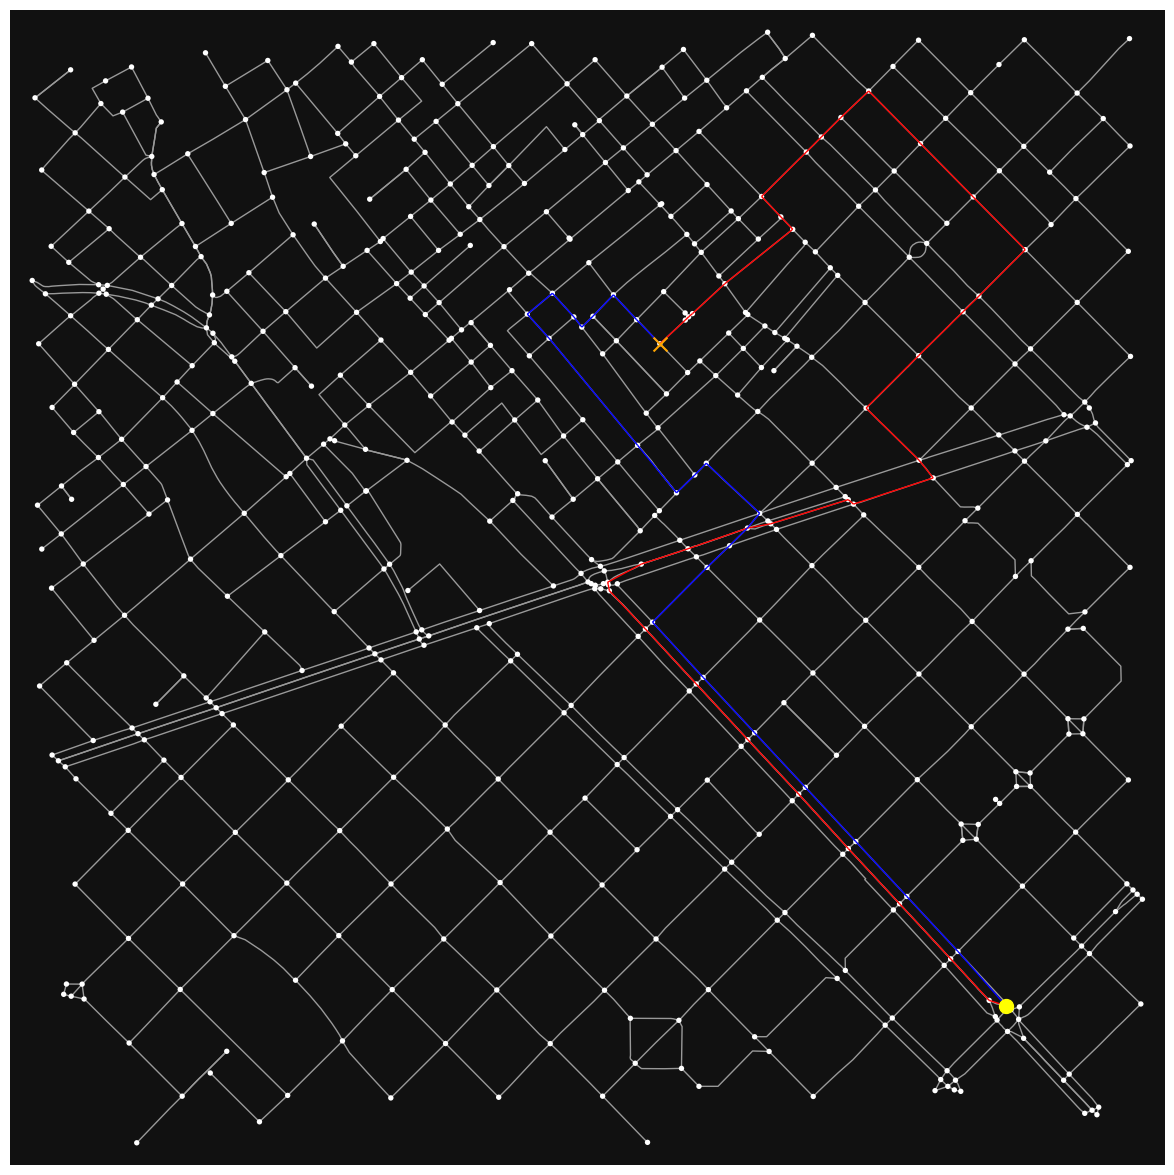

In [ ]:
# Plot the graph
fig, ax = ox.plot_graph(G,  figsize=(15, 15), show=False, close=False)

# Get node positions, stored in node attribute 'pos'
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Highlight route_cost in red
path_edges_A = list(zip(route_cost[:-1], route_cost[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges_A, edge_color='red', width=1, ax=ax, arrows=False)

# Highlight route_cost_neg in blue
path_edges_B = list(zip(route_cost_neg[:-1], route_cost_neg[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges_B, edge_color='blue', width=1, ax=ax, arrows=False)

# Highlight the source nodes for both paths
source_nodes = {route_cost[0], route_cost_neg[0]}
nx.draw_networkx_nodes(G, pos, nodelist=list(source_nodes), node_color='yellow', node_size=100, ax=ax)

# Highlight the target nodes for both paths with 'X' marker
target_nodes = {route_cost[-1], route_cost_neg[-1]}
nx.draw_networkx_nodes(G, pos, nodelist=list(target_nodes), node_color='orange', node_size=100, node_shape='x', ax=ax)


# Show the plot
plt.show()